Примеры:
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb
* http://localhost:8888/notebooks/examples/2/%D0%94%D0%B5%D0%BC%D0%BE%D0%BD%D1%81%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F-BigARTM-0.8.0.ipynb

In [8]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [9]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [34]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре"
)


# Фильтрация

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_tf", 
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_tf", 
)

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.001)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_df_rate", 
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.6)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_df_rate", 
)

  75725 - количество слов в словаре
  19855 - количество слов в словаре после фильтрации по min_tf
  19310 - количество слов в словаре после фильтрации по max_tf
   9315 - количество слов в словаре после фильтрации по min_df_rate
   9315 - количество слов в словаре после фильтрации по max_df_rate


In [11]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        # Названия тем
        topic_names=['topic_{0:0>3}'.format(i) for i in range(topic_count)], 
        # Разрешается хранить матрицу theta в памяти
        cache_theta=True,
        # Фиксация seed для воспроизвдимости результатов
        seed=-1,
        # Настройка - сколько раз обрабатывать каждый документ
        num_document_passes=1,
        # Модальности
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [12]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = plt.subplot2grid((4,3), (0,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)

    ax = plt.subplot2grid((4,3), (0,1), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (0,2), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (1,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (1,1), colspan = 2, rowspan = 1,  fig=fig)
    my_contrast_dictionary = model_artm.score_tracker['TopicKernelScore'].last_contrast
    ax.bar(my_contrast_dictionary.keys(), my_contrast_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (2,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (2,1), colspan = 2, rowspan = 1,  fig=fig)
    my_purity_dictionary = model_artm.score_tracker['TopicKernelScore'].last_purity
    ax.bar(my_purity_dictionary.keys(), my_purity_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (3,0), colspan = 1, rowspan = 1,  fig=fig)
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])

    ax = plt.subplot2grid((4,3), (3,1), colspan = 2, rowspan = 1,  fig=fig)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

In [13]:
params = {
    'topic_count': 15,
    'num_collection_passes': 40,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5,
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3,
    },
    'DecorrelatorPhi': {
        'name': 'DecorrelatorPhi',
        'tau': 25_000_000,
    }
}

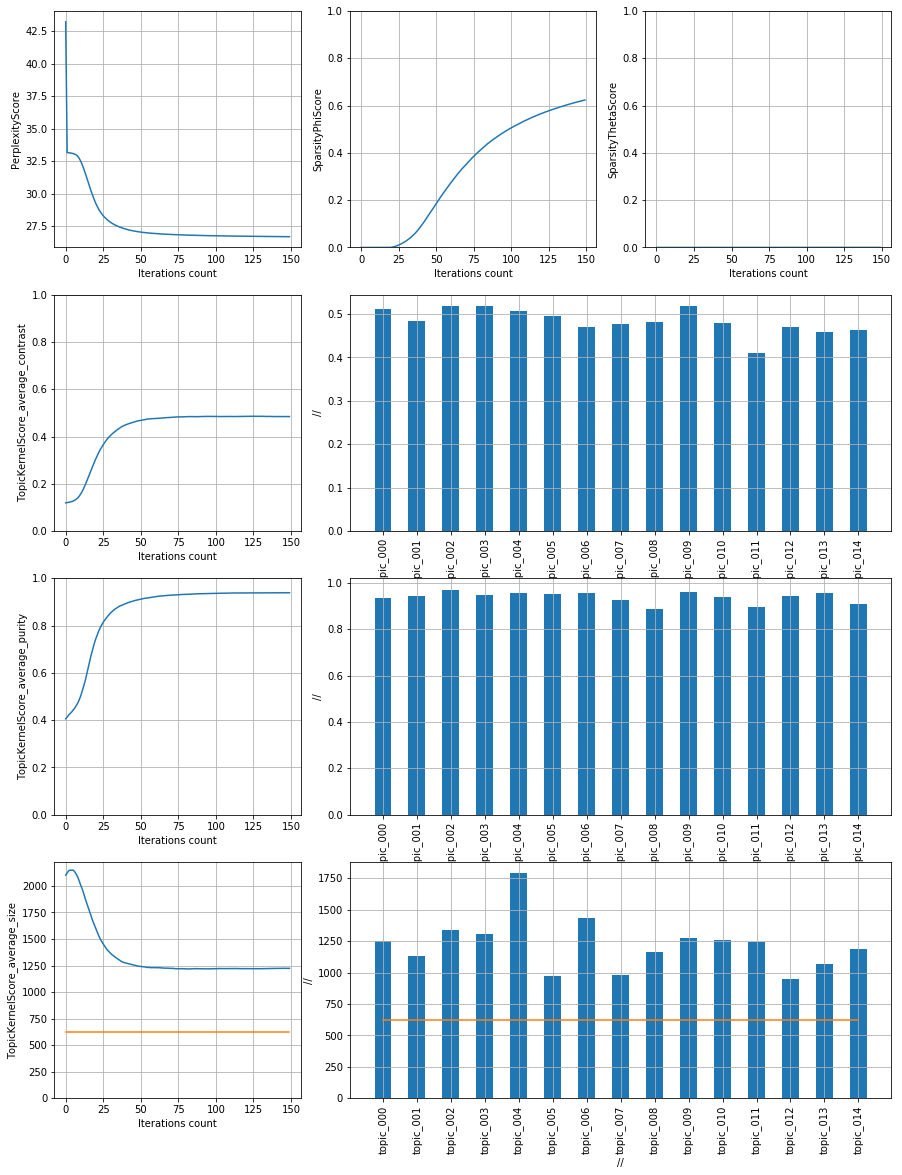

PerplexityScore: 26.68313217163086
SparsityPhiScore: 0.6236965656280518
SparsityThetaScore: 0.0002576516999397427

TopicKernelScore_average_contrast: 0.48437264561653137
TopicKernelScore_average_purity: 0.9390180706977844
TopicKernelScore_average_size: 1223.5999755859375

TopTokensScore:
topic_000: изолятор умирать исправительный зона голодовка оказывать освобождение отбывать болотный переводить 
topic_001: партия выборы открытый инфо оппозиционер сторонник оштрафовать твиттер протест координатор 
topic_002: бить дверь ударять увидеть домой кабинет комната повреждение позвонить угрожать 
topic_003: предприятие особо бизнесмен мошенничество миллион счет банк зарплата строительство рабочий 
topic_004: например мало тюрьма приходиться часто здесь история студент хороший нужно 
topic_005: служебный превышение подросток тяжкий причинение девочка несовершеннолетний совершенный кража родитель 
topic_006: помнить задавать читать смотреть вспоминать обсуждать специалист зудхаймер зачитывать пер

In [14]:
# Создание базовой пустой модели
model_artm = new_default_model(params['topic_count'], dictionary)

# Модель 0_0
# Запуск регуляризатора SparsePhi

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=150)

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_0")
model_artm_0_0 = model_artm.clone()

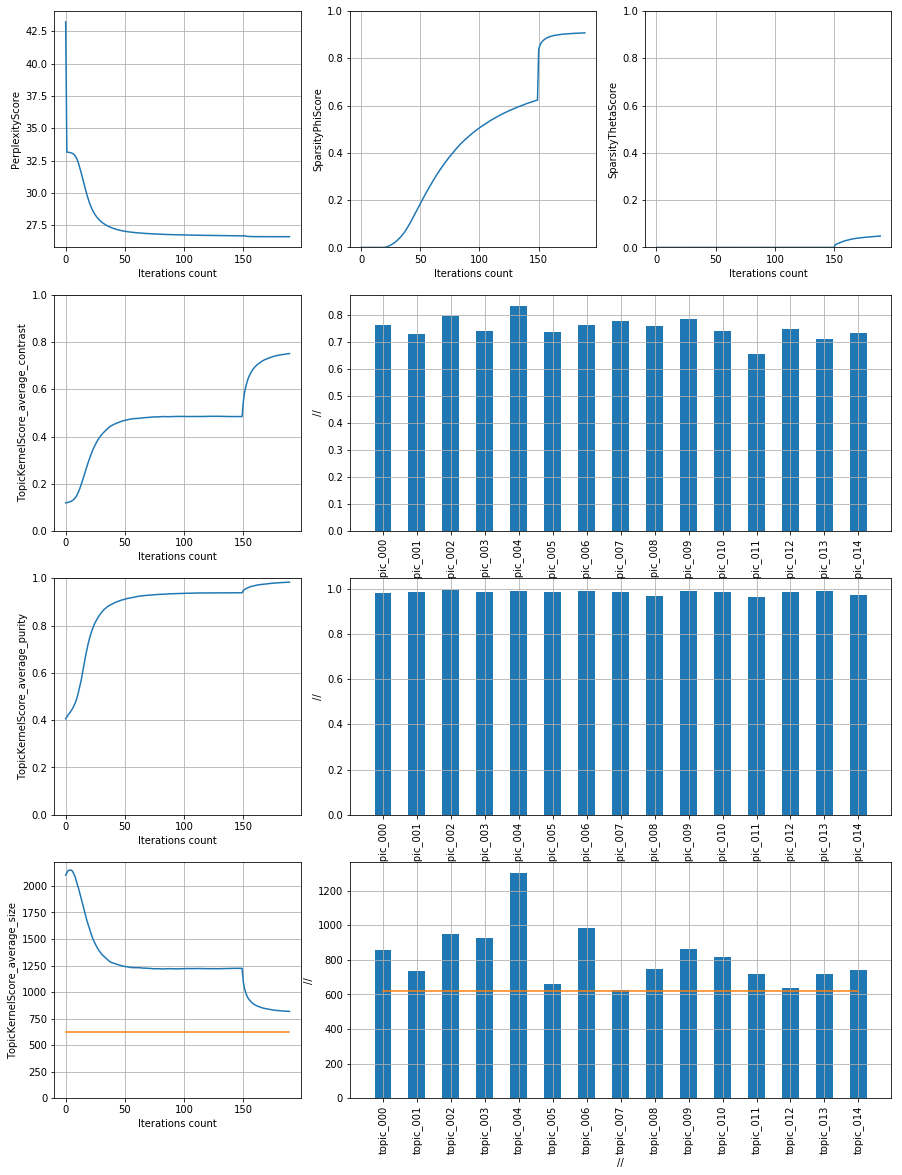

PerplexityScore: 26.618301391601562
SparsityPhiScore: 0.9078046083450317
SparsityThetaScore: 0.04844984412193298

TopicKernelScore_average_contrast: 0.7511212825775146
TopicKernelScore_average_purity: 0.983912467956543
TopicKernelScore_average_size: 818.066650390625

TopTokensScore:
topic_000: изолятор умирать освобождение исправительный зона голодовка оказывать отбывать болотный переводить 
topic_001: партия выборы открытый инфо оппозиционер сторонник протест твиттер оштрафовать правонарушение 
topic_002: ударять дверь бить увидеть домой кабинет комната повреждение угрожать позвонить 
topic_003: особо предприятие бизнесмен мошенничество миллион счет банк зарплата рабочий строительство 
topic_004: мало например приходиться тюрьма часто здесь рано любой ходить разный 
topic_005: служебный превышение подросток тяжкий причинение девочка несовершеннолетний совершенный кража родитель 
topic_006: помнить задавать читать специалист смотреть вспоминать переходить обсуждать зачитывать оглашать 

In [15]:
# Модель 0_1
# Запуск регуляризатора SparsePhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора, если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_1")
model_artm_0_1 = model_artm.clone()

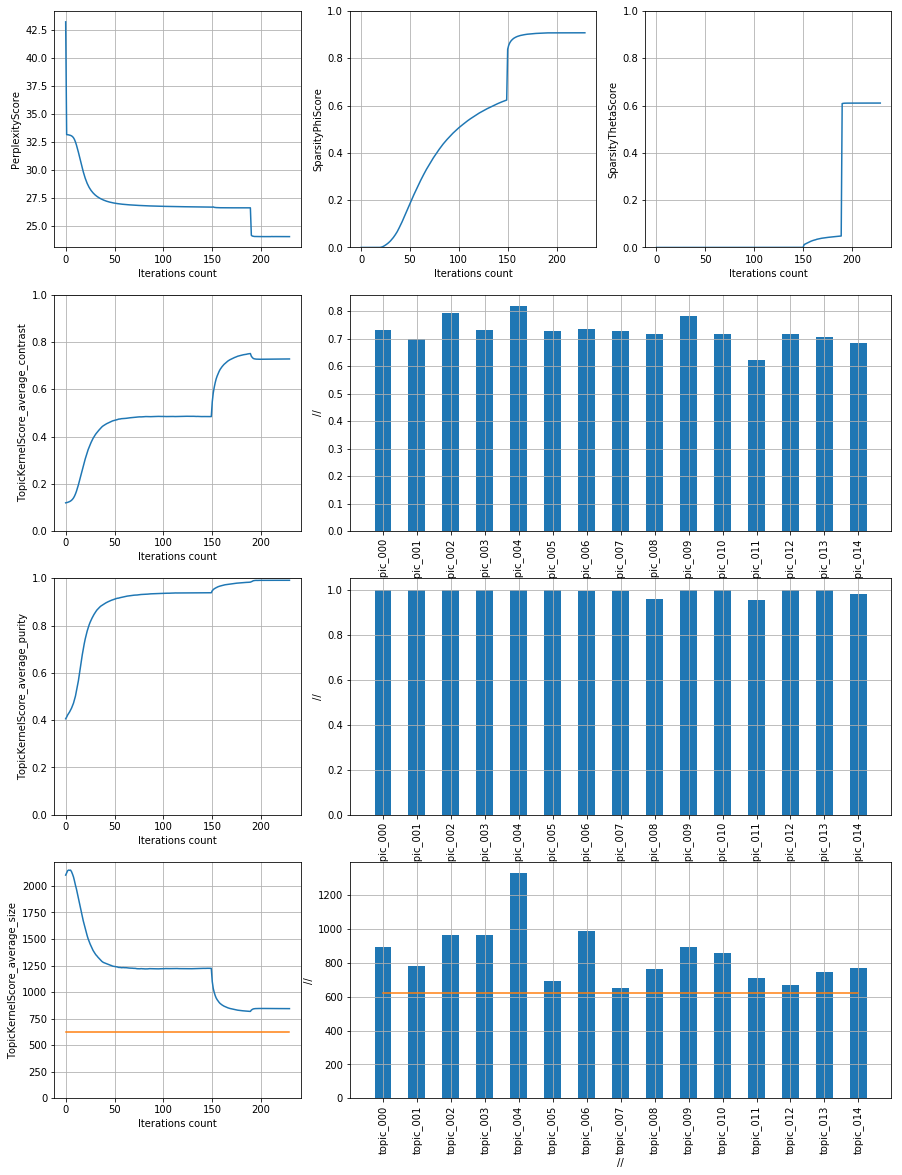

PerplexityScore: 24.047178268432617
SparsityPhiScore: 0.9082053899765015
SparsityThetaScore: 0.6109091639518738

TopicKernelScore_average_contrast: 0.7281849980354309
TopicKernelScore_average_purity: 0.991706132888794
TopicKernelScore_average_size: 844.3333129882812

TopTokensScore:
topic_000: изолятор голодовка исправительный освобождение зона болотный отбывать лечение умирать переводить 
topic_001: партия выборы инфо оппозиционер открытый сторонник координатор твиттер протест пикет 
topic_002: бить ударять дверь домой увидеть комната кабинет наручник глаз позвонить 
topic_003: предприятие бизнесмен особо мошенничество миллион счет банк зарплата строительство предприниматель 
topic_004: например часто здесь ходить нужно мало тюрьма хороший приходиться думать 
topic_005: превышение подросток служебный тяжкий причинение девочка несовершеннолетний совершенный кража детский 
topic_006: помнить задавать читать вспоминать смотреть зачитывать зудхаймер перерыв обсуждать полозов 
topic_007: п

In [16]:
# Модель 0_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

# Загрузка модели
model_artm = model_artm_0_1.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_2")
model_artm_0_2 = model_artm.clone()

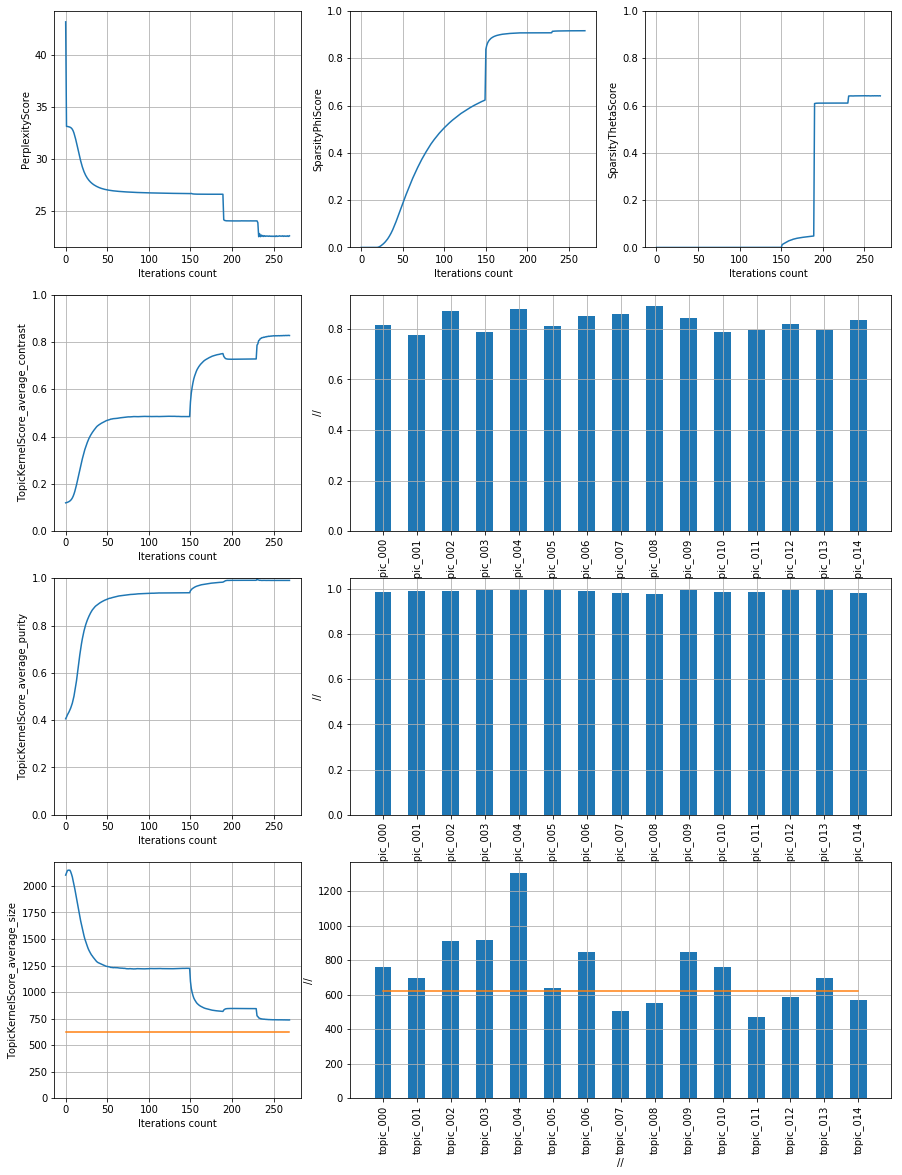

PerplexityScore: 22.613672256469727
SparsityPhiScore: 0.9169225096702576
SparsityThetaScore: 0.6413771510124207

TopicKernelScore_average_contrast: 0.8273970484733582
TopicKernelScore_average_purity: 0.9912153482437134
TopicKernelScore_average_size: 737.933349609375

TopTokensScore:
topic_000: изолятор скорый голодовка зона исправительный освобождение беспорядок болотный половина переводить 
topic_001: партия выборы открытый инфо оппозиционер подпись протест оштрафовать сторонник политик 
topic_002: бить ударять дверь увидеть повреждение вернуться угрожать подходить позвонить кабинет 
topic_003: предприятие бизнесмен особо мошенничество миллион договор рабочий счет банк зарплата 
topic_004: сидеть нужно здесь почти пойти думать разный любой хорошо конечно 
topic_005: подросток превышение служебный тяжкий причинение девочка привлекать несовершеннолетний родитель дочь 
topic_006: помнить вспоминать минута задавать специалист читать встречаться зачитывать обращать обсуждать 
topic_007: вз

In [17]:
# Модель 0_3
# Запуск регуляризатора DecorrelatorPhi к уже включенным SparsePhi, SparseTheta

# Загрузка модели
model_artm = model_artm_0_2.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_3")
model_artm_0_3 = model_artm.clone()

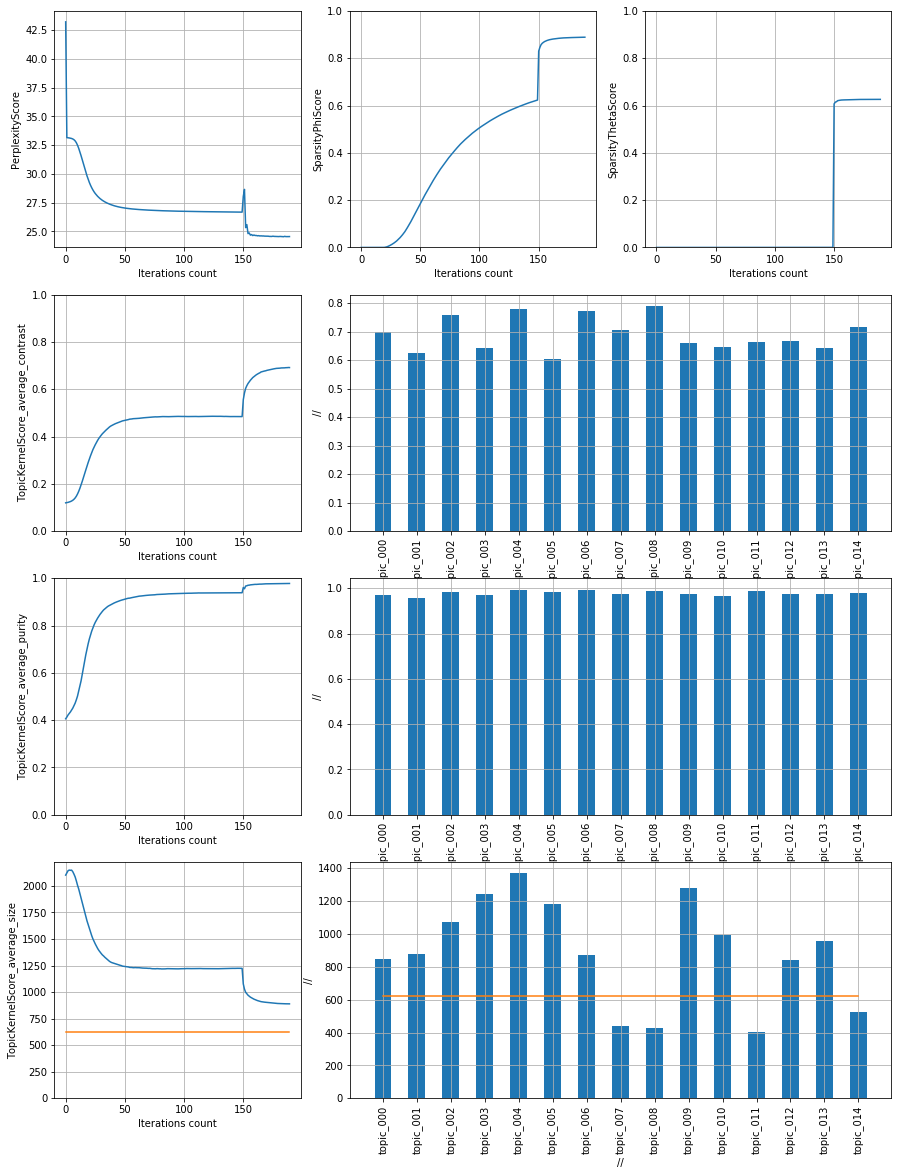

PerplexityScore: 24.557884216308594
SparsityPhiScore: 0.8895329833030701
SparsityThetaScore: 0.6265437602996826

TopicKernelScore_average_contrast: 0.6917584538459778
TopicKernelScore_average_purity: 0.9782660007476807
TopicKernelScore_average_size: 889.3333129882812

TopTokensScore:
topic_000: сидеть изолятор умирать оказывать скорый травма голодовка исправительный освобождение болотный 
topic_001: партия выборы юрий снова подписывать инфо оппозиционер подпись соглашаться открытый 
topic_002: бить ударять увидеть дверь повреждение вернуться подходить позвонить домой угрожать 
topic_003: предприятие бизнесмен возможность мошенничество миллион особо договор счет чиновник третий 
topic_004: нужно пойти здесь разный любой хорошо конечно почти например часто 
topic_005: отец превышение служебный удаваться подросток николай правый сначала тяжкий гражданский 
topic_006: помнить вспоминать минута задавать специалист читать встречаться зачитывать обращать никита 
topic_007: взрыв теракт покуше

In [18]:
# Альтернативная модель 1_0
# Запуск одновременно 3 регуляризаторов SparsePhi, SparseTheta, DecorrelatorPhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_1_0")
model_artm_1_0 = model_artm.clone()

In [19]:
phi = model_artm.phi_
phi

,topic_000,topic_001,topic_002,topic_003,topic_004,topic_005,topic_006,topic_007,topic_008,topic_009,topic_010,topic_011,topic_012,topic_013,topic_014
белые,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000368,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
дубовик,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000861,0.000000,0.000000
павликова,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001193,0.000000,0.000000
костюченко,0.000000,0.000594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
щерчок,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
сысолятин,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
щерчков,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
когуп,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
дятлов,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
отмывать,0.000000,0.000000,0.000000,0.000135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
theta = model_artm.get_theta()
theta

,9000,9001,9002,9003,9004,9005,9006,9007,9008,9009,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
topic_000,0.023978,0.036188,0.012233,0.394284,0.022066,0.028322,0.088226,0.026950,0.050124,0.079040,...,0.023539,3.794792e-02,3.896470e-02,0.004070,0.068073,0.070166,0.023208,0.045963,0.017989,0.032166
topic_001,0.032418,0.061746,0.034057,0.008326,0.469951,0.023507,0.029529,0.017147,0.279353,0.070189,...,0.071958,4.310974e-02,1.214148e-01,0.060028,0.233967,0.023297,0.012168,0.109908,0.031587,0.185882
topic_002,0.040682,0.026182,0.071086,0.062007,0.022028,0.033344,0.090152,0.144620,0.020975,0.014978,...,0.043834,4.533009e-02,3.430738e-05,0.021391,0.160491,0.026096,0.016888,0.023490,0.028835,0.010772
topic_003,0.009432,0.013023,0.029461,0.001101,0.048002,0.027489,0.002495,0.066672,0.057327,0.009529,...,0.047986,3.565253e-02,2.031540e-02,0.026400,0.026111,0.049849,0.029735,0.243055,0.364442,0.148407
topic_004,0.015466,0.037494,0.041212,0.119358,0.025630,0.159800,0.097737,0.060074,0.077476,0.071815,...,0.040230,4.565836e-02,5.028040e-07,0.005287,0.079426,0.011332,0.049730,0.008981,0.013020,0.045020
topic_005,0.036516,0.073599,0.041935,0.151789,0.082710,0.051487,0.252882,0.210902,0.032118,0.044162,...,0.125251,1.017568e-01,2.364298e-02,0.034780,0.028612,0.041403,0.081536,0.014172,0.021524,0.100906
topic_006,0.055567,0.054379,0.037097,0.001943,0.054788,0.088633,0.045288,0.020079,0.032937,0.041391,...,0.009187,1.510733e-04,5.574623e-04,0.002818,0.029667,0.035324,0.046375,0.011746,0.013803,0.020004
topic_007,0.125847,0.293375,0.088624,0.091613,0.003712,0.116952,0.028100,0.092045,0.030714,0.009799,...,0.077422,8.277981e-02,1.224409e-01,0.469584,0.029502,0.154458,0.189091,0.046927,0.082680,0.049800
topic_008,0.400251,0.018881,0.387434,0.009241,0.036202,0.041179,0.046613,0.044410,0.056973,0.102241,...,0.036029,5.716594e-02,2.248326e-02,0.008370,0.019172,0.012425,0.012362,0.338100,0.048184,0.015354
topic_009,0.142777,0.014178,0.095425,0.060738,0.014627,0.033957,0.119609,0.130640,0.010567,0.009036,...,0.409068,4.920858e-01,3.906030e-01,0.035625,0.076291,0.099052,0.237999,0.063732,0.051546,0.034915
